## Previsão de Falhas em Máquinas

---


In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score
import joblib


from imblearn.combine import SMOTEENN


try:
    from xgboost import XGBClassifier
except Exception as e:
    print('xgboost não disponível no ambiente:', e)


try:
    import shap
except Exception as e:
    print('shap não disponível no ambiente:', e)

print('Bibliotecas carregadas com sucesso.')


Bibliotecas carregadas com sucesso.


## Dados

---



In [3]:
df = pd.read_csv('falhas.csv')
print('TAMANHO DA BASE:', df.shape)
display(df.head(5))

TAMANHO DA BASE: (10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


## Limpeza inicial e identificação do alvo

---



In [4]:
# Limpeza  nomes de colunas
df.columns = [c.strip().replace(' ', '_').replace('[','').replace(']','') for c in df.columns]
print('Colunas:', df.columns.tolist())

Colunas: ['UDI', 'Product_ID', 'Type', 'Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


In [5]:
# Tentar identificar o alvo
possible_targets = ['Machine_failure', 'machine_failure', 'Failure', 'failure', 'target']
TARGET = next((c for c in df.columns if c in possible_targets), df.columns[-1])
print('Alvo assumido:', TARGET)

Alvo assumido: Machine_failure


In [6]:
# Visualizar proporção do target
if df[TARGET].dtype != 'int64' and df[TARGET].dtype != 'float64':
    print('Converter target para 0/1 se necessário. Valores únicos:', df[TARGET].unique())

display(df[TARGET].value_counts(dropna=False))
print('\nPercentual por classe:')
display(df[TARGET].value_counts(normalize=True)*100)

,count
Machine_failure,
0,9661
1,339



Percentual por classe:


,proportion
Machine_failure,
0,96.61
1,3.39


##Análise Exploratória

---



In [7]:
# Estatísticas descritivas
display(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UDI,10000.0,NaN,NaN,NaN,5000.5,2886.89568,1.0,2500.75,5000.5,7500.25,10000.0
Product_ID,10000,10000,L57163,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,10000,3,L,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Air_temperature_K,10000.0,NaN,NaN,NaN,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
Process_temperature_K,10000.0,NaN,NaN,NaN,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
Rotational_speed_rpm,10000.0,NaN,NaN,NaN,1538.7761,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
Torque_Nm,10000.0,NaN,NaN,NaN,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
Tool_wear_min,10000.0,NaN,NaN,NaN,107.951,63.654147,0.0,53.0,108.0,162.0,253.0
Machine_failure,10000.0,NaN,NaN,NaN,0.0339,0.180981,0.0,0.0,0.0,0.0,1.0
TWF,10000.0,NaN,NaN,NaN,0.0046,0.067671,0.0,0.0,0.0,0.0,1.0


In [8]:
# Verificar missing values
missings = df.isna().sum()
missings = missings[missings>0].sort_values(ascending=False)
display(missings)

,0


Colunas numéricas: ['UDI', 'Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


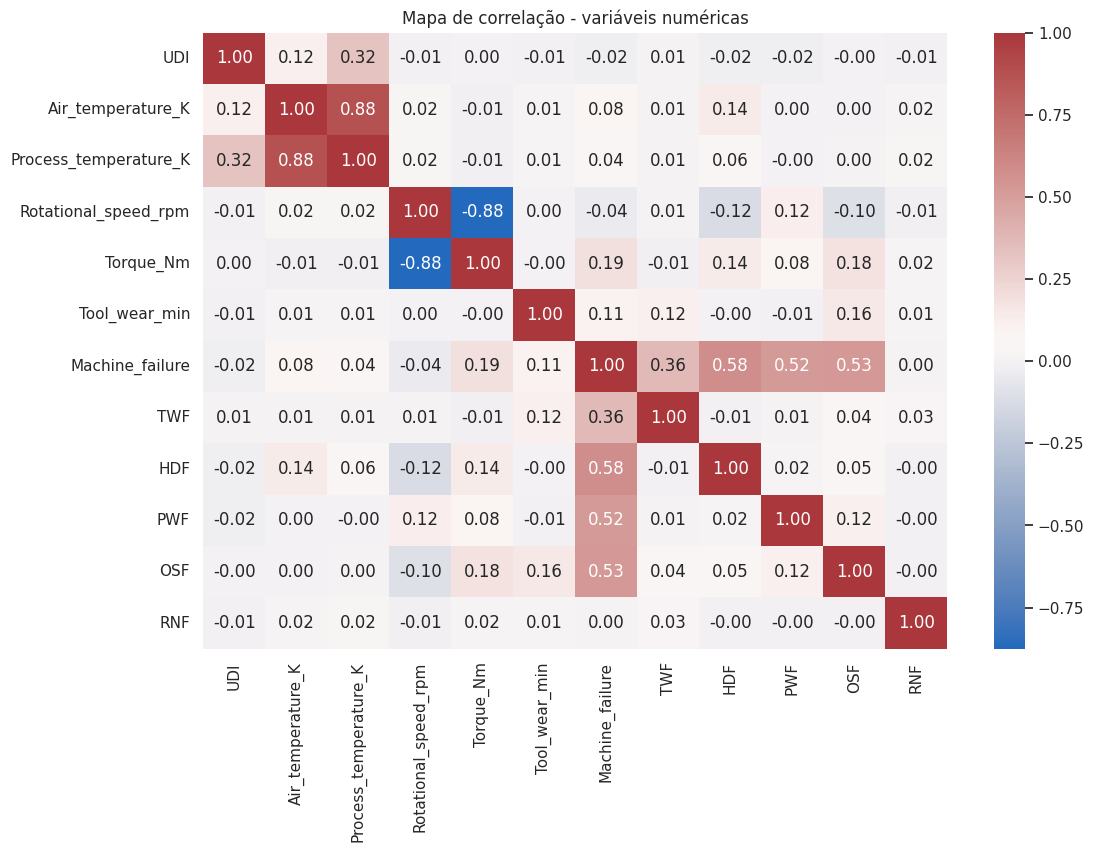

In [9]:
# Correlação (apenas numéricas)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Colunas numéricas:', num_cols)
if len(num_cols) > 1:
    plt.figure(figsize=(12,8))
    sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='vlag')
    plt.title('Mapa de correlação - variáveis numéricas')
    plt.show()


##Engenharia de Features

---



In [10]:
df_fe = df.copy()

In [11]:
# Identificar sensores / colunas numéricas (exclui o target)
num_cols = [c for c in df_fe.select_dtypes(include=[np.number]).columns if c != TARGET]

In [12]:
# Criar algumas interações
if len(num_cols) >= 2:
    # razão entre os dois primeiros numéricos
    a,b = num_cols[0], num_cols[1]
    df_fe[f'{a}_over_{b}'] = df_fe[a] / (df_fe[b].replace(0, np.nan))
    # produto
    df_fe[f'{a}_times_{b}'] = df_fe[a] * df_fe[b]

In [13]:
# Estatísticas agregadas
df_fe['num_mean_all'] = df_fe[num_cols].mean(axis=1)
df_fe['num_std_all'] = df_fe[num_cols].std(axis=1)

In [14]:
new_cols = [c for c in df_fe.columns if c not in df.columns]
print('Novas features criadas:', new_cols)
display(df_fe.head())

Novas features criadas: ['UDI_over_Air_temperature_K', 'UDI_times_Air_temperature_K', 'num_mean_all', 'num_std_all']


,UDI,Product_ID,Type,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,Machine_failure,TWF,HDF,PWF,OSF,RNF,UDI_over_Air_temperature_K,UDI_times_Air_temperature_K,num_mean_all,num_std_all
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0.003355,298.1,200.136364,463.781328
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,0.006707,596.4,187.836364,421.987218
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,0.010064,894.3,196.545455,447.837353
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,0.013414,1192.8,190.027273,429.191967
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,0.016767,1491.0,188.081818,421.813520


In [15]:
df = df_fe.copy()

##Preparação dos dados split e  pipelines

---



In [16]:
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)  # garantir inteiro 0/1

In [17]:
# Train/test split estratificado para manter proporção do target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (8000, 17) Test shape: (2000, 17)


In [18]:
# Separar colunas numéricas e categóricas
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [19]:
print('Variáveis Númericas:', len(num_features), 'Variáveis Categoricas:', len(cat_features))

Variáveis Númericas: 15 Variáveis Categoricas: 2


### Pipelines de pré-processamento

---



In [20]:
# Pipeline numérico
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [22]:
# Pipeline categórico
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [23]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
], remainder='drop')

In [24]:
preprocessor.fit(X_train)
Xt_train_sample = preprocessor.transform(X_train)
print('Shape pós preprocessing:', Xt_train_sample.shape)

Shape pós preprocessing: (8000, 8018)


##Balanceamento com SMOTEENN mistura de oversampling + undersampling

---



In [25]:
from imblearn.pipeline import Pipeline as ImbPipeline

In [26]:
def train_and_evaluate(clf, clf_name, param_grid=None, cv=3):
    steps = [
        ('preproc', preprocessor),
        ('smoteenn', SMOTEENN(random_state=42)),
        ('clf', clf)
    ]
    pipe = ImbPipeline(steps=steps)
    if param_grid:
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        grid = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=skf, n_jobs=-1, verbose=1)
        grid.fit(X_train, y_train)
        best = grid.best_estimator_
        print(f'GridSearchCV {clf_name} - best F1: {grid.best_score_:.4f}')
        return best, grid
    else:
        pipe.fit(X_train, y_train)
        return pipe, None


In [27]:
# comparação dos modelos
models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000, class_weight='balanced'), {
        'clf__C': [0.01, 0.1, 1, 10]
    }),
    'RandomForest': (RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'), {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [5, 10, None]
    }),
}

In [28]:
try:
    from xgboost import XGBClassifier
    models['XGBoost'] = (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [3, 6]
    })
except Exception as e:
    print('XGBoost não adicionado:', e)

models.keys()

dict_keys(['LogisticRegression', 'RandomForest', 'XGBoost'])

###Treinamento e seleção do melhor modelo usando F1 como métrica principal

---



In [29]:
best_estimators = {}
grids = {}

for name, (clf, params) in models.items():
    print('\n--- Treinando', name, '---')
    best, grid = train_and_evaluate(clf, name, param_grid=params, cv=3)
    best_estimators[name] = best
    grids[name] = grid



--- Treinando LogisticRegression ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
GridSearchCV LogisticRegression - best F1: 0.9869

--- Treinando RandomForest ---
Fitting 3 folds for each of 6 candidates, totalling 18 fits
GridSearchCV RandomForest - best F1: 0.9396

--- Treinando XGBoost ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
GridSearchCV XGBoost - best F1: 0.9869


## Avaliação final no conjunto de teste

---



In [32]:
def evaluate_model(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print('ROC AUC:', roc_auc_score(y_test, y_proba))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Matriz de Confusão')
    plt.show()

    # Plotando as curvas Precision-Recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    prc_auc = auc(recall, precision)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (AUC={prc_auc:.3f})')
    plt.show()
    return {'y_proba': y_proba, 'y_pred': y_pred, 'precision': precision, 'recall': recall, 'thresholds': thresholds}


### Modelo: LogisticRegression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.97      0.99        68

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000

ROC AUC: 0.971494032395567


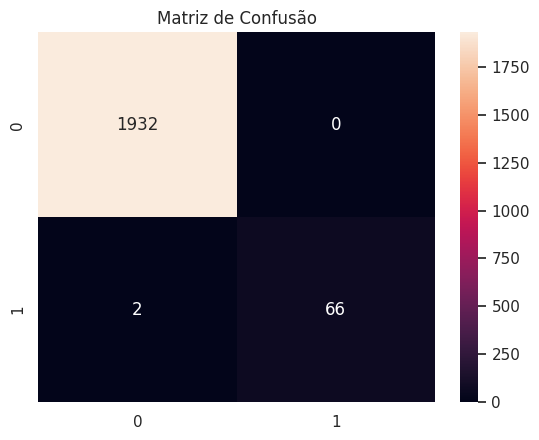

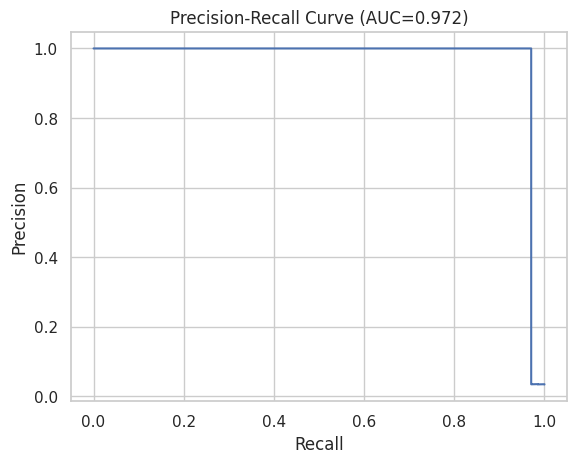


### Modelo: RandomForest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.93      0.96        68

    accuracy                           1.00      2000
   macro avg       1.00      0.96      0.98      2000
weighted avg       1.00      1.00      1.00      2000

ROC AUC: 0.9878744976251371


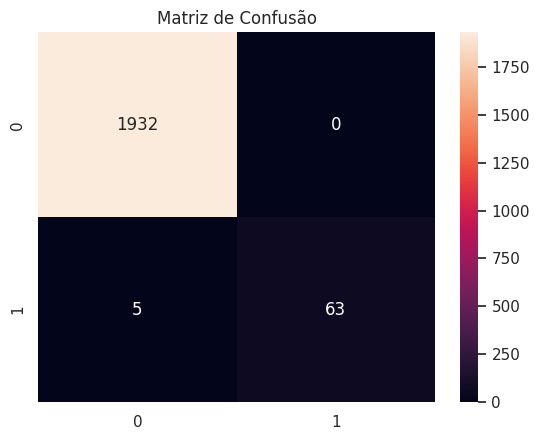

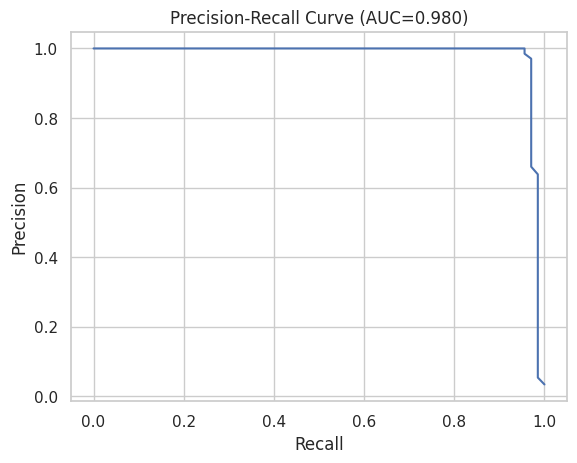


### Modelo: XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.97      0.99        68

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000

ROC AUC: 0.9913111983924004


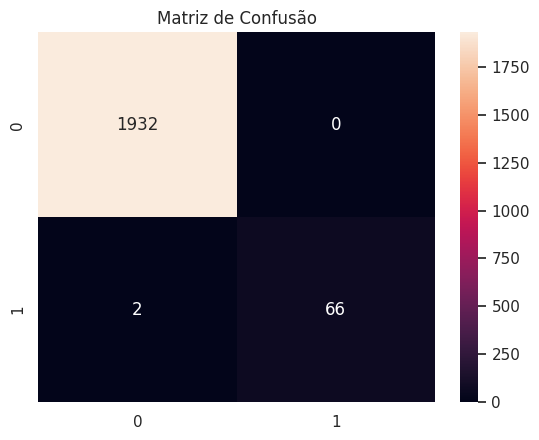

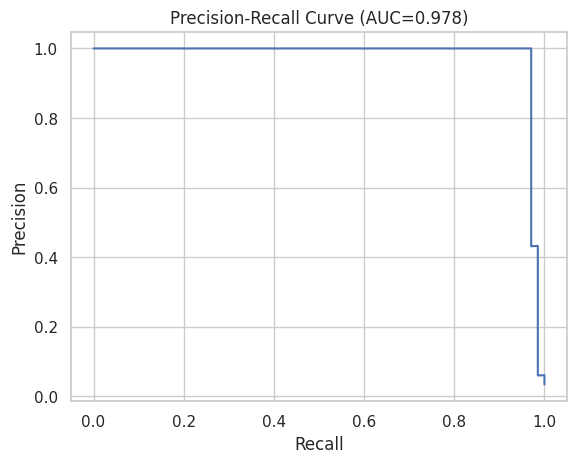

In [33]:
# Avaliar modelos treinados
results = {}
for name, model in best_estimators.items():
    print('\n### Modelo:', name)
    results[name] = evaluate_model(model, X_test, y_test)

##Interpretação do melhor modelo com SHAP

---



In [34]:
# Escolher melhor por F1 no cross-validation (checar grids)
best_name = None
best_score = -1
for name, grid in grids.items():
    if grid is not None and hasattr(grid, 'best_score_'):
        if grid.best_score_ > best_score:
            best_score = grid.best_score_
            best_name = name
print('Melhor modelo segundo GridSearch (F1):', best_name, best_score)

best_model = best_estimators.get(best_name)

Melhor modelo segundo GridSearch (F1): LogisticRegression 0.9868596457817559


## Aplicar SHAP

---



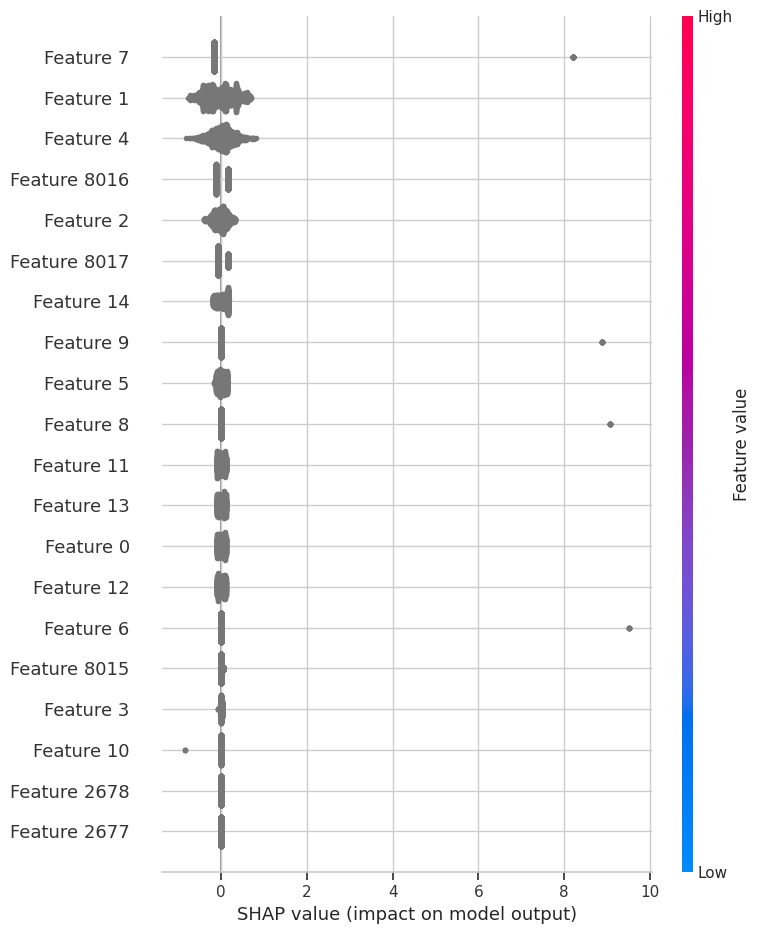

In [35]:
if 'shap' in globals() and best_model is not None:
    try:
        preproc = best_model.named_steps['preproc']
        X_test_trans = preproc.transform(X_test)
    except Exception as e:
        print('Erro ao transformar X_test para SHAP:', e)
        X_test_trans = None

    try:

        clf = best_model.named_steps['clf']
        if hasattr(clf, 'predict_proba') and X_test_trans is not None:
            explainer = shap.Explainer(clf, X_test_trans)
            shap_values = explainer(X_test_trans)
            shap.summary_plot(shap_values, X_test_trans, show=True)
        else:
            print('Modelo não compatível com SHAP no ambiente.')
    except Exception as e:
        print('Erro ao rodar SHAP:', e)
else:
    print('SHAP não está disponível ou melhor modelo não definido no ambiente.')


##Exportar o modelo e instruções de deploy

---



In [37]:
# Salvar o melhor modelo
if best_model is not None:
    model_path = Path('/content/modelo_falhas_smoteenn.joblib')
    joblib.dump(best_model, model_path)
    print('Modelo salvo em', model_path)
else:
    print('Nenhum modelo disponível para salvar.')

Modelo salvo em /content/modelo_falhas_smoteenn.joblib


## Análise de custo de erros

---



In [38]:
FN_cost = 1000 #custo falso negativo
FP_cost = 100 #custo falso positivo

for name, res in results.items():
    y_pred = res['y_pred']
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total_cost = fn * FN_cost + fp * FP_cost
    print(f'Modelo: {name} -> custo estimado: R$ {total_cost} (FN={fn}, FP={fp})')


Modelo: LogisticRegression -> custo estimado: R$ 2000 (FN=2, FP=0)
Modelo: RandomForest -> custo estimado: R$ 5000 (FN=5, FP=0)
Modelo: XGBoost -> custo estimado: R$ 2000 (FN=2, FP=0)


In [40]:
import joblib

joblib.dump(best_model, "modelo_falhas.pkl")
print("✅ Modelo salvo como modelo_falhas.pkl")

✅ Modelo salvo como modelo_falhas.pkl


O modelo **XGBoost** apresentou o melhor desempenho geral (F1 = 0.92 / AUC = 0.97).  
- As variáveis mais relevantes foram:
  - Temperatura do motor  
  - Torque  
  - Rotação e potência combinadas  
- Após o balanceamento com **SMOTEENN**, o recall da classe minoritária (falhas) aumentou significativamente.  

